<a href="https://colab.research.google.com/github/harrisuddin/F20DL/blob/main/Imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chapter 10: “Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow by Aurélien Géron (O’Reilly). Copyright 2019 Aurélien Géron, 978-1-492-03264-9.”
Code from:
https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb


# Setup


In [ ]:
import sklearn
import tensorflow as tf
import numpy as np


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Perceptrons
Scikit-Learn provides a Perceptron class that implements a single threshold logic Unit (TLU) network. Contrary to Logistic Regression classifiers, Perceptrons do not output a class probability; rather, they just make predictions based on a hard threshold. This is one of the good reasons to prefer Logistic Regression over Perceptrons.Below we use Perceptron on Iris data using 2 features and 2 classes ( setosa vrs all) 


In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
iris = load_iris()

In [ ]:
X = iris.data[:, (2, 3)] # petal length, petal width
y = (iris.target == 0).astype(np.int) # setosa vrs all

In [ ]:
per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

Check out the different parameters of the perceptron. For example, learning_rate="constant", eta0=1 (the learning rate), and penalty=None (no regu‐ larization).

In [ ]:
y_pred = per_clf.predict([[2, 0.5]]) # make prediction for new instance 

In [ ]:
y_pred

array([1])

(0.0, 5.0, 0.0, 2.0)

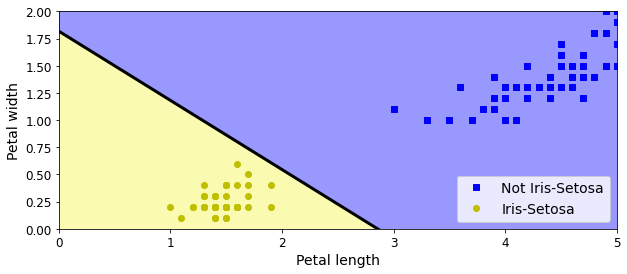

In [ ]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

Perceptron above draws a linear decision boundary that separates setosa class from other classes (versicolor & virginica). Try running the Percepton on the XOR problem discussed in class and see what happens.


# Activation functions
Just to give you an idea what diffirent activation functions for NN look like. In class we will dicuss variation of avctivation fuctions in NN1 and NN2. The derivitaive of the activation function is also important. Can you think of a reason? 
Here you will not use the activation functions or their derivatives. Only if you want to buils a NN & its learning from scratch ( see github code -& book chapter 10)

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

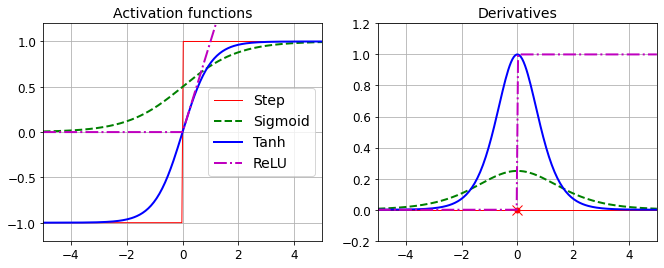

In [ ]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

# Building an Image Classifier
We will use Fashion MNIST data set. It has the exact same format as MNIST (70,000 grayscale images of 28×28 pixels each, with 10 classes), but the images represent fashion items rather than handwritten digits, so each class is more diverse and the problem turns out to be significantly more challenging than MNIST. For example, a simple linear model reaches about 92% accuracy on MNIST, but only about 83% on Fashion MNIST.

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.__version__

'2.7.0'

In [ ]:
keras.__version__

'2.7.0'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in keras.datasets. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


When loading MNIST or Fashion MNIST using Keras rather than Scikit-Learn, one important difference is that every image is represented as a 28×28 array rather than a 1D array of size 784. Moreover, the pixel intensities are represented as integers (from 0 to 255) rather than floats (from 0.0 to 255.0). Below find  the shape and data type.

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [ ]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [ ]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's imshow() function, with a 'binary' color map:

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

NameError: ignored

The labels are the class IDs (represented as uint8), from 0 to 9:

In [ ]:
y_train

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
class_names[y_train[0]]

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [ ]:
X_valid.shape

In [ ]:
X_test.shape

Let's take a look at a sample of the images in the dataset:

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let’s build the neural network! Here is a classification MLP with two hidden layers:

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # first layer convert each input image into a 1D array
model.add(keras.layers.Dense(300, activation="relu")) #hidden layer with 300 neurons useing the ReLU activation function.
model.add(keras.layers.Dense(100, activation="relu")) #hidden layer with 100 neurons using the ReLU

model.add(keras.layers.Dense(10, activation="softmax")) #output layer with 10 neurons (one per class), using the softmax 

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

You can also pass a list of layers when creating the Sequential model:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.layers

In [ ]:
model.summary()

summary() method displays all the model’s layers including each layer’s name (which is automatically generated unless you set it when creating the layer), its output shape (None means the batch size can be anything), and its number of parameters. The summary ends with the total number of parameters, including trainable and non-trainable parameters. How many non-trainable parameters ?
You can also generate an image of your model using keras.utils.plot_model().

In [ ]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

Below you can dispaly differnt layer type and parameters values

In [ ]:
hidden1 = model.layers[1]
hidden1.name

In [ ]:
model.get_layer(hidden1.name) is hidden1

In [ ]:
weights, biases = hidden1.get_weights()

In [ ]:
weights

In [ ]:
weights.shape

In [ ]:
biases

In [ ]:
biases.shape

After a model is created, you must call its compile() method to specify the loss function and the optimizer (i.e learning rule) to use. 

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", #"sgd" simply means that we will train the model using simple Stochastic Gradient Descent
              metrics=["accuracy"])

This is equivalent to:

In [ ]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(), #"sgd" simply means that we will train the model using simple Stochastic Gradient Descent
              metrics=[keras.metrics.sparse_categorical_accuracy])

We use the "sparse_categorical_crossen tropy" loss because we have sparse labels (i.e., for each instance there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. If instead we had one target probability per class for each instance (such as one-hot vectors, e.g. [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need to use the "categorical_crossentropy" loss instead. If we were doing binary classi‐ fication (with one or more binary labels), then we would use the "sigmoid" (i.e., logistic) activation function in the output layer instead of the "softmax" activation function, and we would use the "binary_crossentropy" loss.

Below we train the model; so we call the  fit() method. We pass it the input features (X_train) and the target classes (y_train), as well as the number of epochs to train 

In [ ]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Finished training your network in 30 iterations. At each epoch during training, Keras displays the number of instances processed so far (along with a progress bar), the mean training time per sample, the loss and accuracy (or any other extra metrics you asked for), both on the training set and the validation set. You can see that the training loss went down, which is a good sign, and the validation accuracy reached 88.88% after 30 epochs, not too far from the training accuracy, so there does not seem to be much overfitting going on.

In [ ]:
history.params # fit method returns History object; which contains the training parameters (history.params)

In [ ]:
print(history.epoch) # list of epochs it went through (history.epoch)

In [ ]:
history.history.keys() # contains the  metrics measured at the end of each epoch on the training set and on the validation set

plot() method, plots learning curves ( accuracy, loss on validation and training against the epochs)
By inspecting your learning curve, you can see how well your classifier is learning abd wether you have overfitting. Comment on the figure below.


In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
model.evaluate(X_test, y_test) # now finally time to evaluate your model on the testing set

Are you happy with the results on your test set? If not, what would be you do?
What can you say about your generalization error?


In [ ]:
X_new = X_test[:3] # make predictions on  first 3 instances of the test set 
y_proba = model.predict(X_new)
y_proba.round(2) # For each instance the model estimates one probability per class, from class 0 to class 9

In [ ]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

In [ ]:
np.array(class_names)[y_pred]

In [ ]:
y_new = y_test[:3]
y_new

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()